 **Financial (Bitcoin price 30 min) trading rules using LSTM**
 
 Version 1.7.1

Jojothepizza/ Jo-cho

1. Financial Data and Bars 
 - OHLCV Bar
 - summary and plot

2. Trend Signals (Long only)
 - TAs (sma, fi, rsi)
 - Combined with CUSUM Filter

3. Labeling
 - Binary Label (Triple Barrier - trading rule)
 - Meta-Labeling (Profit or Loss (use for prediction)

4. Prediction of whether bet or not

 4.1. Features (X)
 - Technical Indicators
 - Feature Scaling (MinMaxScaler)
 - Feature Selection (PCA)
 
 4.2. Prediction
 - Train/test set : Simple Split
 - Model: LSTM
 - Metrics ()

5. Results
 - CUM Returns, Sharpe Ratio


In [1]:
# mlfinlab (BIG THANKS TO DE PRADO and HUSONTHAMES)
import mlfinlab
from mlfinlab import data_structures, features, labeling, util, sampling
from mlfinlab import filters as flt
from mlfinlab import structural_breaks, microstructural_features, cross_validation, feature_importance
from mlfinlab import bet_sizing as bs

# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.stats import norm, moment

#feature
from sklearn import preprocessing
from sklearn.decomposition import PCA 

# CV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

#ML
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

#Tensorflow & Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import regularizers
from keras.utils.vis_utils import plot_model

# statistical tests
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro

# technical analysis
import ta

# Pyfolio
import pyfolio as pf


C:\Users\JHCho\anaconda3\envs\py37\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# Financial Data and Bars

## OHLCV Bar

- BTC/USD 
- 30 minutes OHLCV(open, high, low, close, volume)

In [3]:
# YOUR API KEYS HERE
api_key = "9VdiXTVwWbYToM0xxxY4EBoRvPr709Nauhu0pIcLwm7ESKVo177KYy54kt6tVo2G"    #Enter your own API-key here
api_secret = "ev9HmZMQkhlzmq90zozGEWNyQKJOyQ4OzgmkE5DaFykLIOXdvL185I6HTsfW89UO" #Enter your own API-secret here

In [4]:
from binance.client import Client
bclient = Client(api_key=api_key, api_secret=api_secret)

In [5]:
start_date = dt.datetime(2018,1,1)
end_date = dt.datetime(2021,1,1)

symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_30MINUTE

In [6]:
def binanceBar(symbol,interval,start_date, end_date):
    
    klines = bclient.get_historical_klines(symbol, interval, start_date.strftime("%d %b %Y %H:%M:%S"), end_date.strftime("%d %b %Y %H:%M:%S"), 1000)
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

    data.set_index('timestamp', inplace=True)
    return data

In [7]:
df = binanceBar(symbol,interval,start_date,end_date)

In [8]:
# Export data

filename = '{}_30MinuteBars.csv'.format(symbol)
df.to_csv(filename)

In [9]:
#Import data

#df_raw = pd.read_csv('BTCUSDT_30MinuteBars.csv')
#df = df_raw.set_index('timestamp')

In [10]:
df.head()

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13400.01,13521.12,221.752443,1514766599999,2997301.73845297,3033,110.913522,1499891.99930118,0
2018-01-01 00:30:00,13500.00,13690.87,13450.00,13529.01,221.603756,1514768399999,2996608.09758503,2195,117.608399,1590649.10646831,0
2018-01-01 01:00:00,13528.99,13595.89,13402.28,13560.00,160.399291,1514770199999,2167760.52857938,1837,79.393609,1072980.54307815,0
2018-01-01 01:30:00,13559.99,13559.99,13155.38,13203.06,223.297715,1514771999999,2986761.02655606,2697,101.446794,1357468.94987857,0
2018-01-01 02:00:00,13203.00,13411.76,13202.03,13225.00,203.728509,1514773799999,2712355.25279372,2607,83.771907,1115103.90829206,0


In [11]:
close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)

df_others = df.iloc[:,5:-1]

## summary & plots

In [12]:
df_ohlcv = pd.DataFrame([open,high,low,close,volume]).T
df_ohlcv.describe()

,open,high,low,close,volume
count,52383.000000,52383.000000,52383.000000,52383.000000,52383.000000
mean,8658.107412,8690.299764,8623.474706,8658.390292,1037.942947
std,3628.650313,3646.144922,3609.591215,3629.671148,1123.092828
min,3166.110000,3176.240000,3156.260000,3167.070000,0.000000
25%,6542.955000,6557.520000,6528.780000,6543.065000,460.852033
50%,8303.330000,8332.490000,8270.890000,8303.350000,725.172957
75%,10138.670000,10175.000000,10100.000000,10138.685000,1193.648336
max,29204.500000,29300.000000,29090.800000,29207.840000,26658.428398


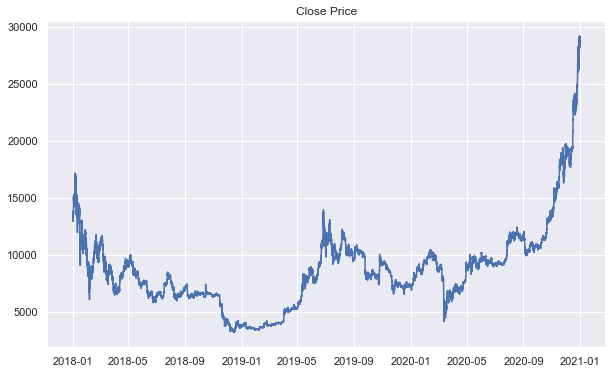

In [13]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('close_price.jpg')
plt.show();

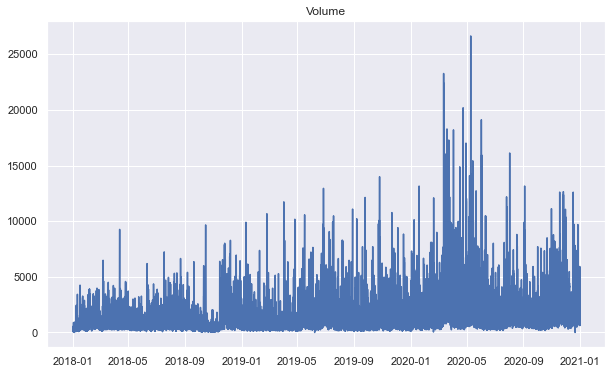

In [14]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('volume.jpg')
plt.show();

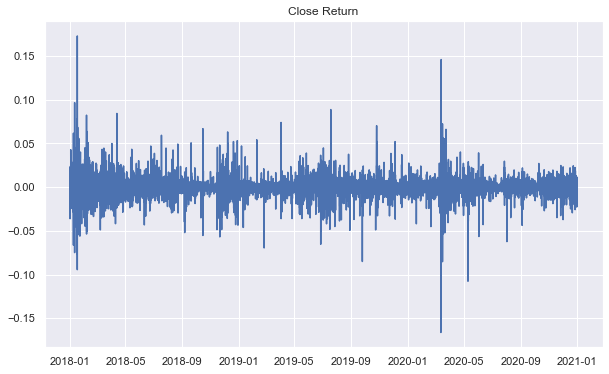

In [15]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('closereturn.jpg')
plt.show();

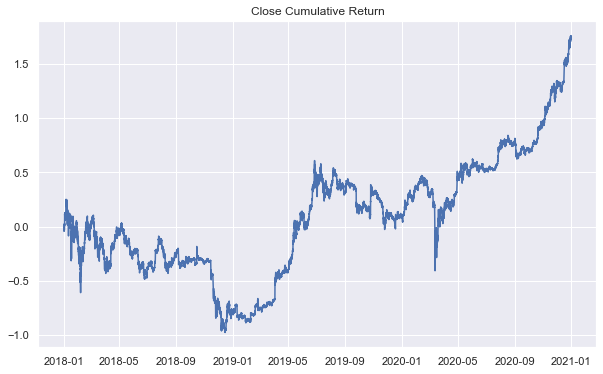

In [16]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.show();

# Trading Strategy

 ## Only long


In [17]:
filters = pd.DataFrame(close)
mt = 48 #  48*(30minutes) = 1 day

In [18]:
# First step: SMA filter
#정배열 = 1, 역배열 = 0

n_f = 10
n_s = 30

sma_f=ta.trend.sma_indicator(close,n_f*mt)
sma_s=ta.trend.sma_indicator(close,n_s*mt)

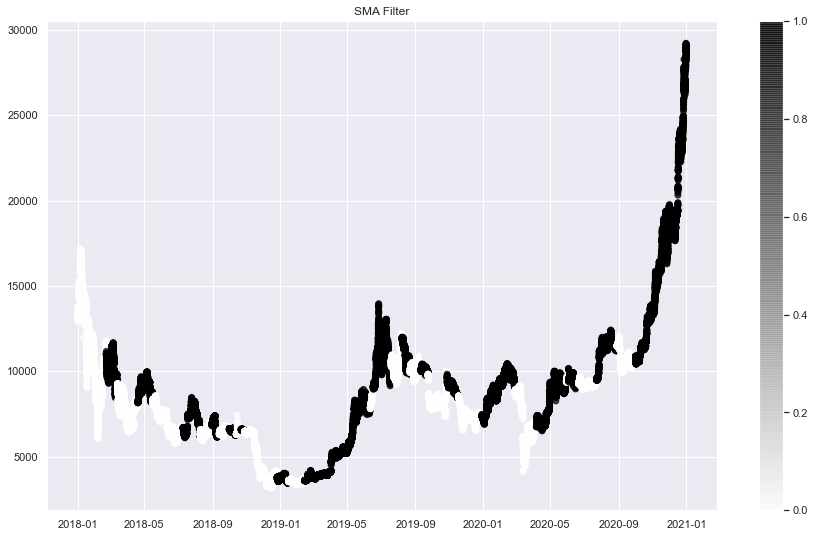

In [19]:
filters['sma'] = np.where(sma_f> sma_s, 1, 0)
#filters.sma.loc[sma_f<sma_s] = -1

plt.figure(figsize=(15,9))
plt.scatter(filters.index, filters.close,c= filters.sma,cmap='gray_r',alpha=0.75)

cb = plt.colorbar()
cb.ax.tick_params()
plt.title('SMA Filter')
plt.savefig('smaf.jpg')
plt.show()

In [20]:
## Second Step Force Index
n=14
fi= ta.volume.ForceIndexIndicator(close,volume,n*mt).force_index()

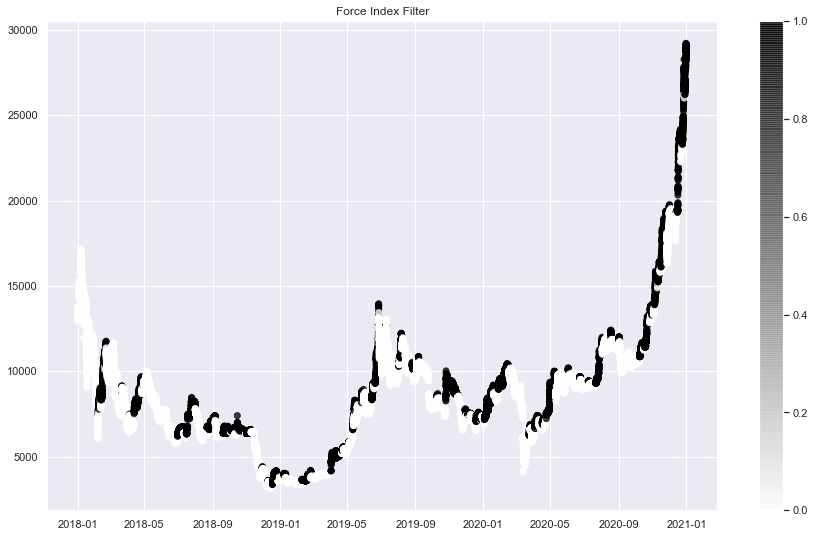

In [21]:
filters['force'] = np.where(fi>0, 1, 0)
#filters.force.loc[fi<0] = -1

plt.figure(figsize=(15,9))
plt.scatter(filters.index, filters.close,c= filters.force,cmap='gray_r',alpha=0.75)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Force Index Filter')
plt.savefig('fi_f.jpg')
plt.show()

In [22]:
## Third Step RSI

rsi = ta.momentum.rsi(close,14*mt)

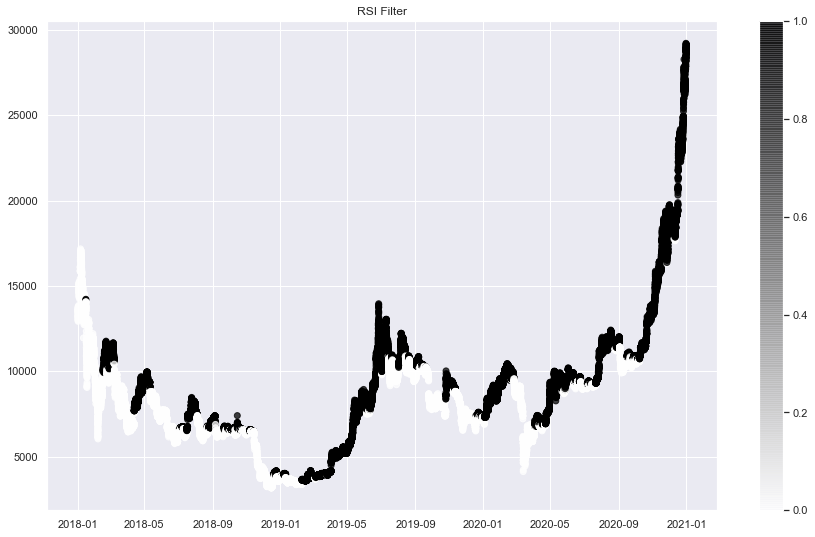

In [23]:
filters['rsi'] = np.where(rsi>50, 1, 0)
#filters.rsi.loc[rsi<50] = -1

plt.figure(figsize=(15,9))
plt.scatter(filters.index, filters.close,c= filters.rsi, cmap='gray_r',alpha=0.75)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('RSI Filter')
plt.savefig('rsi_f.jpg')
plt.show()

## Combined

In [24]:
fil_sum = filters.iloc[:,1:].sum(axis=1)

signal_0 = pd.Series(0,index=close.index)
signal_0.loc[fil_sum==3] = 1.0

In [25]:
signal_0

timestamp
2018-01-01 00:00:00    0
2018-01-01 00:30:00    0
2018-01-01 01:00:00    0
2018-01-01 01:30:00    0
2018-01-01 02:00:00    0
                      ..
2020-12-31 22:00:00    1
2020-12-31 22:30:00    1
2020-12-31 23:00:00    1
2020-12-31 23:30:00    1
2021-01-01 00:00:00    1
Length: 52383, dtype: int64

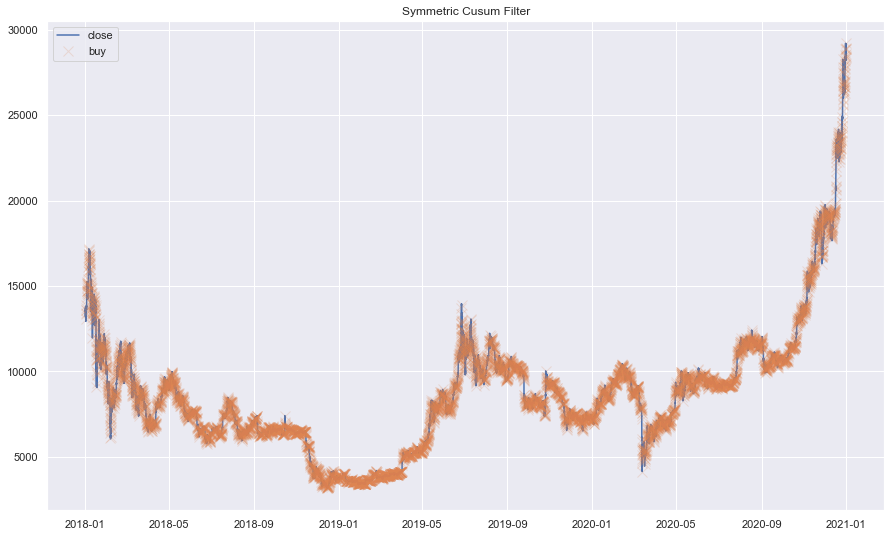

In [26]:
cusum = flt.cusum_filter(close, 2*close.pct_change().rolling(mt).std())

plt.figure(figsize=(15,9))
plt.plot(filters.close,label='close')
plt.plot(cusum, close.loc[cusum], 
         marker='x',linestyle = 'None', markersize=10, label = 'buy', alpha=0.2)



plt.title('Symmetric Cusum Filter')
plt.legend()
plt.savefig('cusum.jpg')
plt.show()

In [27]:
signal = signal_0.loc[cusum]

or select one filter (ex. FI) to figure out which filter is the best

```
signal = filters.filtername
```

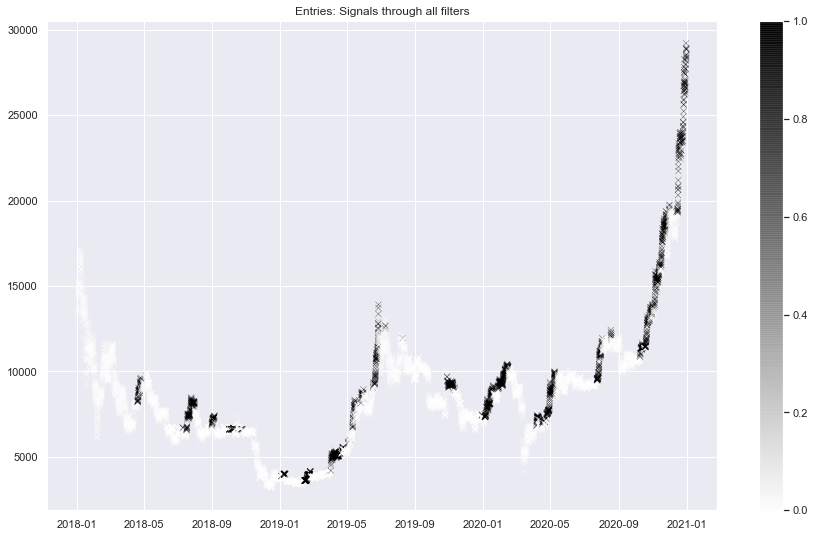

In [29]:
plt.figure(figsize=(15,9))
plt.scatter(signal.index, filters.close.loc[signal.index],c= signal,linewidth=0.3,marker='x' ,cmap='gray_r',alpha=0.9)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Entries: Signals through all filters')
plt.savefig('entries.jpg')
plt.show()

In [30]:
signal

2018-01-02 00:00:00    0
2018-01-02 02:00:00    0
2018-01-02 04:00:00    0
2018-01-02 07:30:00    0
2018-01-02 12:00:00    0
                      ..
2020-12-31 12:00:00    1
2020-12-31 13:00:00    1
2020-12-31 15:00:00    1
2020-12-31 16:30:00    1
2020-12-31 18:30:00    1
Length: 8160, dtype: int64

# Labeling

In [31]:
# Triple-Barrier

rollvol = close.pct_change(mt).ewm(100).std() # daily volatility of 100 rolling days

side = signal.loc[signal!=0]
t_events = side.index

pt_sl = [1,1] # 익절 손절 수평 배리어 크기의 비율

target = rollvol
num_days = mt*30 # 최대 투자 기간

vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=num_days) 
min_ret = 0.0025 # The minimum target return. (주식거래 수수료(세금)로 설정합니다.)

In [32]:
events0 = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=4,  vertical_barrier_times = vertical_barrier_times)
bin0 = labeling.get_bins(events0, close)
bin0 = bin0.dropna()

2021-01-10 20:02:47.252827 100.0% apply_pt_sl_on_t1 done after 0.07 minutes. Remaining 0.0 minutes.


In [33]:
events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=4, side_prediction = side, vertical_barrier_times = vertical_barrier_times)
bin = labeling.get_bins(events, close)

2021-01-10 20:02:52.694277 100.0% apply_pt_sl_on_t1 done after 0.07 minutes. Remaining 0.0 minutes.


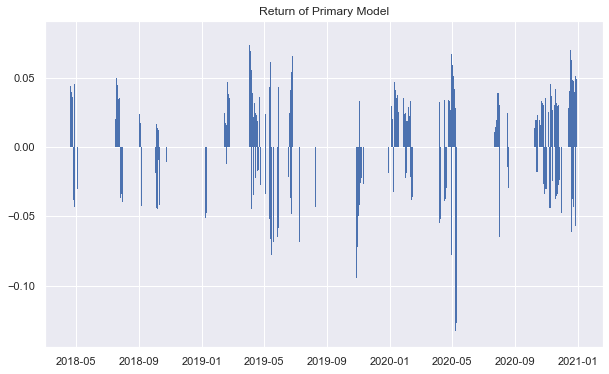

In [34]:
# 실현된 수익률
plt.figure(figsize=(10,6))
plt.title('Return of Primary Model')
plt.bar(bin.index,bin.ret,linewidth=0)
plt.savefig('return_of_1stmodel.jpg')
plt.show();

In [35]:
first_model = pd.DataFrame()

first_model['y_pred'] = side
first_model['y_true'] = np.sign(bin.side*bin.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

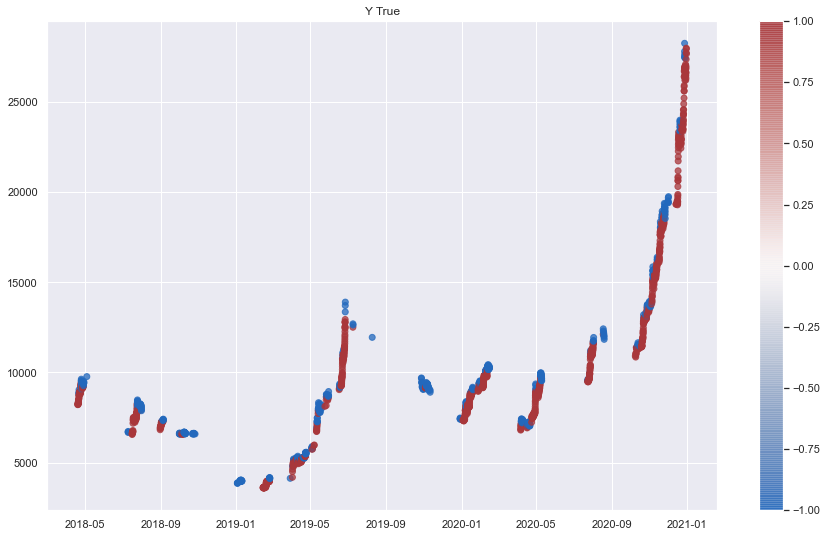

In [36]:
plt.figure(figsize=(15,9))
plt.scatter(first_model.index, close.loc[first_model.index] ,c= y_true1,cmap='vlag',alpha=0.75)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Y True')
plt.show()

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       666
         1.0       0.63      1.00      0.78      1155

    accuracy                           0.63      1821
   macro avg       0.32      0.50      0.39      1821
weighted avg       0.40      0.63      0.49      1821

Accuracy =  0.6342668863261944


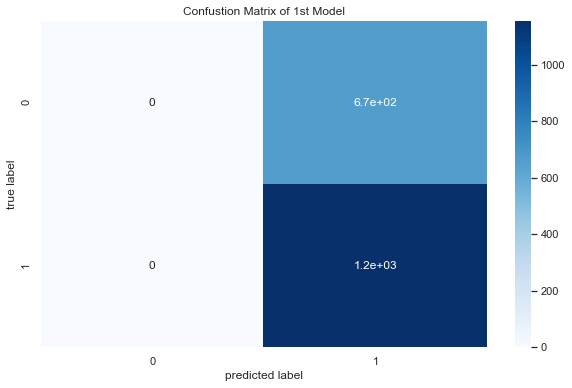

In [39]:
print(classification_report(y_true1, y_pred1))
print("Accuracy = ", accuracy_score(y_true1, y_pred1))

mat = confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10,6))
sns.heatmap(mat , cmap=plt.cm.Blues, annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');
plt.title('Confustion Matrix of 1st Model')
plt.savefig('cm1.jpg')

## Meta Labeling

In [40]:
#y = pd.Series(0,index=first_model.index,name='meta_y')
#y.loc[y_true1==y_pred1]=1
#y

y = bin.bin

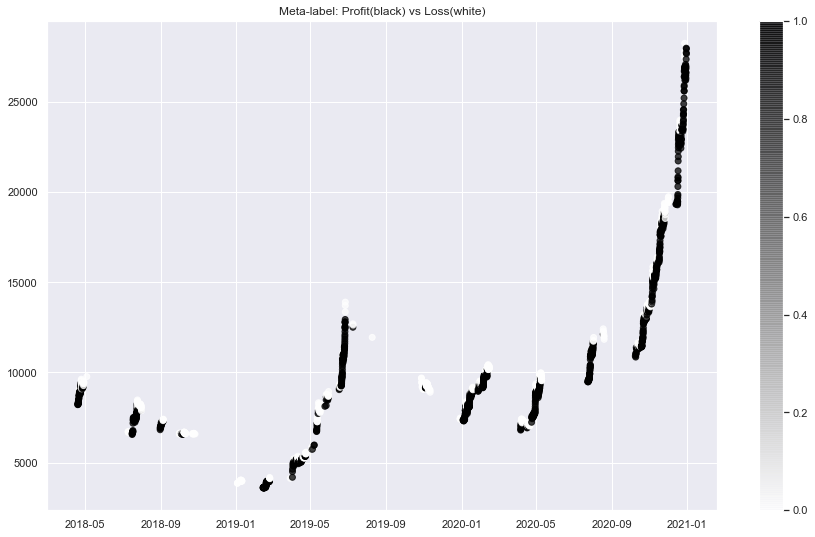

In [41]:
plt.figure(figsize=(15,9))
plt.scatter(y.index, close.loc[y.index] ,c= y,cmap='gray_r',alpha=0.75)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Meta-label: Profit(black) vs Loss(white)')
plt.savefig('metalabel.jpg')
plt.show()

# Trading

## Features


Features that decides bet size

In [42]:
# MACD
macd = sma_f - sma_s

In [43]:
adi = ta.volume.acc_dist_index(high,low,close,volume)
chaikin = ta.volume.chaikin_money_flow(high,low,close,volume,n=20*mt)
atr = ta.volatility.average_true_range(high,low,close,n=14*mt)
mi = ta.trend.mass_index(high,low,n=9*mt,n2=25*mt)
adx = ta.trend.ADXIndicator(high,low,close,n=14*mt).adx()
tsi = ta.momentum.tsi(close,r=25*mt,s=13*mt)
ao = ta.momentum.ao(high,low,s=5*mt,len=34*mt)
wr = ta.momentum.WilliamsRIndicator(high,low,close,14*mt).wr()*-1

In [44]:
r1 = close.pct_change()
r5 = close.pct_change(5)
r10 = close.pct_change(10)
r48 = close.pct_change(48)
r100 = close.pct_change(100)

In [45]:
raw_X = pd.DataFrame({'macd':macd, 'fi':fi,'rsi':rsi,'wr':wr,
                     'adi':adi,'chaikin':chaikin,'atr':atr,'mi':mi,'adx':adx,'tsi':tsi,'ao':ao,'wr':wr,
                     'r1':r1,'r5':r5,'r10':r10,'r48':r48,'r100':r100,
                     'close':close})
raw_X = raw_X.join(df_others)

# Remove look ahead bias
raw_X = raw_X.shift(1).dropna()
raw_X = raw_X.replace([np.inf, -np.inf], np.nan)

In [46]:
raw_X

,macd,fi,rsi,wr,adi,chaikin,atr,mi,adx,tsi,...,r5,r10,r48,r100,close,close_time,quote_av,trades,tb_base_av,tb_quote_av
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-14 10:00:00,-1984.260069,764.756043,49.004577,47.951081,-1.919323e+04,-0.035800,193.992583,1091.348583,10.411436,-2.701134,...,-0.008938,-0.000800,0.039366,0.034131,8762.98,1.518602e+12,4235140.67503273,8099.0,256.214646,2251538.38991769
2018-02-14 10:30:00,-1980.536104,826.000262,49.036378,46.635910,-1.916312e+04,-0.035272,193.809588,1090.975265,10.404650,-2.697703,...,-0.007870,0.005033,0.040902,0.007163,8800.36,1.518604e+12,5036213.26664106,8586.0,293.068433,2580914.47303508
2018-02-14 11:00:00,-1976.391569,766.397756,49.006328,46.960595,-1.959886e+04,-0.035982,193.620853,1090.603304,10.397888,-2.694477,...,-0.012211,-0.009196,0.032107,0.000646,8763.66,1.518606e+12,4608526.83754508,7190.0,257.323013,2262984.07910466
2018-02-14 11:30:00,-1972.265736,795.225516,49.024519,46.551042,-1.947624e+04,-0.035481,193.392251,1090.231297,10.391135,-2.691148,...,-0.007693,-0.008297,0.040806,0.011048,8785.00,1.518608e+12,4308962.38456169,7726.0,184.537071,1621357.54326452
2018-02-14 12:00:00,-1968.088000,1210.272234,49.145416,43.825808,-1.853379e+04,-0.034483,193.334599,1089.860396,10.383992,-2.687048,...,0.014547,0.014571,0.046361,0.018084,8927.00,1.518610e+12,8766042.15450562,13013.0,609.357516,5404949.47694136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:00:00,3805.362583,4322.358984,54.579929,4.457448,2.440648e+06,0.111958,212.749259,1276.806613,3.684112,8.187451,...,0.001382,0.020639,0.003157,0.075552,28966.36,1.609452e+12,35340469.27407766,24369.0,504.039026,14657283.05205374
2020-12-31 22:30:00,3811.271236,4544.098351,54.646386,3.167535,2.441081e+06,0.111548,212.729959,1277.076437,3.679607,8.192340,...,0.005713,0.014614,0.006945,0.081180,29062.91,1.609454e+12,23733532.93171605,17245.0,312.281059,9065360.56167020
2020-12-31 23:00:00,3816.613181,4600.584284,54.672480,2.660788,2.441158e+06,0.111903,212.559201,1277.343427,3.675023,8.197416,...,0.007417,0.018510,0.013829,0.078223,29100.84,1.609456e+12,18073589.95827440,19168.0,332.752527,9685216.98583612


## Feature Scaling

 
minmax

In [47]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X)
raw_X_scaled = scaler.transform(raw_X)

scaled_X = pd.DataFrame(raw_X_scaled,index=raw_X.index,columns=raw_X.columns)

## Feature Selection
- PCA

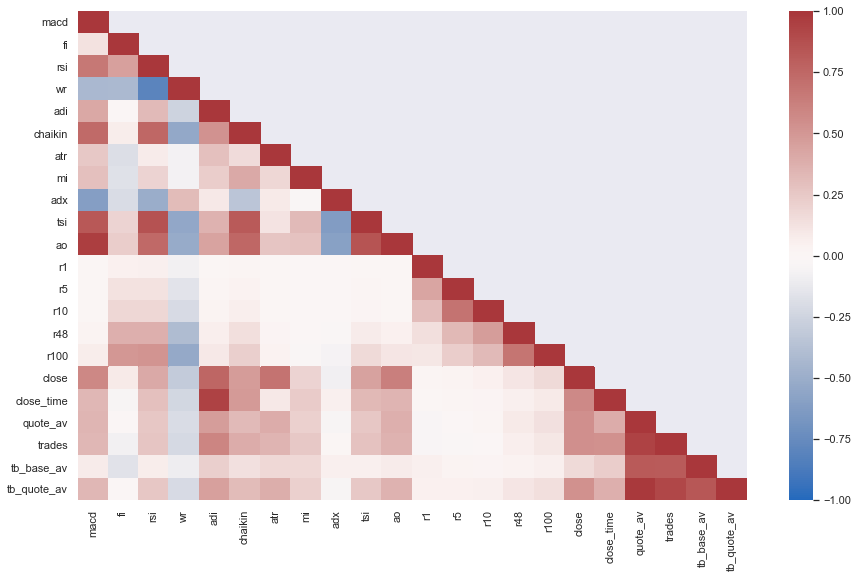

In [48]:
corr = scaled_X.corr().where(np.tril(np.ones(scaled_X.corr().shape)).astype(np.bool))
f = plt.figure(figsize=(15, 9))
sns.heatmap(corr,cmap='vlag',vmin=-1)
plt.show();

In [183]:
# PCA

n=4
pca = PCA(n)
pca.fit(scaled_X)
X_pca = pca.transform(scaled_X)

pca_X = pd.DataFrame(X_pca, index=scaled_X.index)
pca_X

,0,1,2,3
timestamp,,,,
2018-02-14 10:00:00,-0.680772,0.078986,-0.186501,0.624985
2018-02-14 10:30:00,-0.675029,0.073444,-0.190649,0.627721
2018-02-14 11:00:00,-0.679217,0.075460,-0.187757,0.622158
2018-02-14 11:30:00,-0.675937,0.071400,-0.192314,0.624704
2018-02-14 12:00:00,-0.656333,0.058088,-0.208364,0.643182
...,...,...,...,...
2020-12-31 22:00:00,1.527666,-0.008949,0.213616,0.152765
2020-12-31 22:30:00,1.527808,-0.019316,0.204345,0.156154
2020-12-31 23:00:00,1.531195,-0.022479,0.202043,0.158403


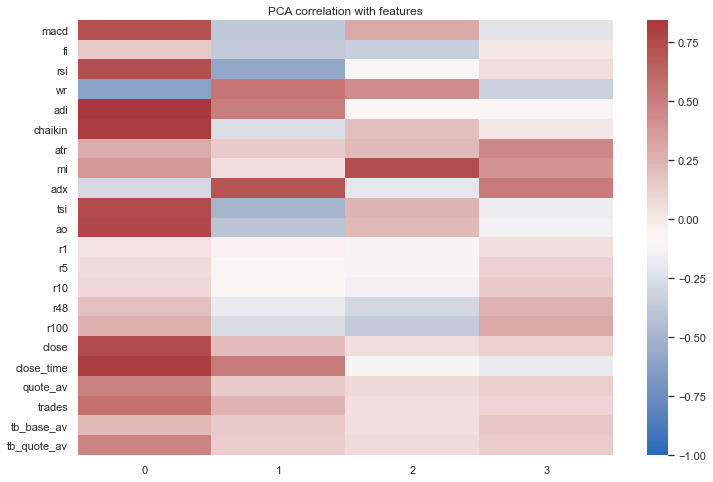

In [184]:
integrated_X = scaled_X.join(pca_X)
corr = integrated_X.corr().where(np.tril(np.ones(integrated_X.corr().shape)).astype(np.bool)).iloc[-n:,:-n].T
f = plt.figure(figsize=(12, 8))
sns.heatmap(corr,cmap='vlag',vmin=-1)
plt.title('PCA correlation with features')
plt.savefig('pcacorr.jpg')
plt.show();

# Machine Learning

In [185]:
tmp_data = pca_X.copy()
tmp_data = tmp_data.join(y)
tmp_data.dropna(inplace=True)

X2 = tmp_data.iloc[:,:-1]
y2 = tmp_data.iloc[:,-1]

In [186]:
t1 = events.t1.loc[X2.index]

## Cross Validation (train-test split)

- For lstm

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.5,shuffle=False)

X_train = X_train.values.reshape((X_train.shape[0],1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1,X_test.shape[1]))

## Models

- Number of neurons -256
- Number of layers - one LSTM and one Dense
- Regularizer - L1 (Lasso)
- Learning rate - 0.01
- Loss - MSE
- Optimizer - Adam
- Metric - Accuarcy

In [219]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

In [220]:
history = model.fit(X_train, y_train, epochs=200, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/200
10/10 - 1s - loss: 1.9747 - accuracy: 0.3802 - val_loss: 1.7386 - val_accuracy: 0.3513
Epoch 2/200
10/10 - 0s - loss: 1.5498 - accuracy: 0.3802 - val_loss: 1.3618 - val_accuracy: 0.3513
Epoch 3/200
10/10 - 0s - loss: 1.1902 - accuracy: 0.3802 - val_loss: 1.0425 - val_accuracy: 0.3513
Epoch 4/200
10/10 - 0s - loss: 0.8903 - accuracy: 0.3802 - val_loss: 0.7767 - val_accuracy: 0.3513
Epoch 5/200
10/10 - 0s - loss: 0.6509 - accuracy: 0.3802 - val_loss: 0.5686 - val_accuracy: 0.3513
Epoch 6/200
10/10 - 0s - loss: 0.4739 - accuracy: 0.3846 - val_loss: 0.4201 - val_accuracy: 0.3513
Epoch 7/200
10/10 - 0s - loss: 0.3564 - accuracy: 0.6121 - val_loss: 0.3312 - val_accuracy: 0.4797
Epoch 8/200
10/10 - 0s - loss: 0.3014 - accuracy: 0.6253 - val_loss: 0.2961 - val_accuracy: 0.6411
Epoch 9/200
10/10 - 0s - loss: 0.2791 - accuracy: 0.6198 - val_loss: 0.2714 - val_accuracy: 0.6487
Epoch 10/200
10/10 - 0s - loss: 0.2661 - accuracy: 0.6198 - val_loss: 0.2581 - val_accuracy: 0.6487
Epoch 11/

Epoch 84/200
10/10 - 0s - loss: 0.2417 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 85/200
10/10 - 0s - loss: 0.2402 - accuracy: 0.6198 - val_loss: 0.2329 - val_accuracy: 0.6487
Epoch 86/200
10/10 - 0s - loss: 0.2433 - accuracy: 0.6198 - val_loss: 0.2329 - val_accuracy: 0.6487
Epoch 87/200
10/10 - 0s - loss: 0.2428 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 88/200
10/10 - 0s - loss: 0.2422 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 89/200
10/10 - 0s - loss: 0.2416 - accuracy: 0.6198 - val_loss: 0.2331 - val_accuracy: 0.6487
Epoch 90/200
10/10 - 0s - loss: 0.2408 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 91/200
10/10 - 0s - loss: 0.2428 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 92/200
10/10 - 0s - loss: 0.2419 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 93/200
10/10 - 0s - loss: 0.2431 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487


Epoch 166/200
10/10 - 0s - loss: 0.2428 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 167/200
10/10 - 0s - loss: 0.2404 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 168/200
10/10 - 0s - loss: 0.2427 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 169/200
10/10 - 0s - loss: 0.2423 - accuracy: 0.6198 - val_loss: 0.2329 - val_accuracy: 0.6487
Epoch 170/200
10/10 - 0s - loss: 0.2421 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 171/200
10/10 - 0s - loss: 0.2415 - accuracy: 0.6198 - val_loss: 0.2331 - val_accuracy: 0.6487
Epoch 172/200
10/10 - 0s - loss: 0.2424 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 173/200
10/10 - 0s - loss: 0.2423 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 174/200
10/10 - 0s - loss: 0.2421 - accuracy: 0.6198 - val_loss: 0.2330 - val_accuracy: 0.6487
Epoch 175/200
10/10 - 0s - loss: 0.2417 - accuracy: 0.6198 - val_loss: 0.2330 - val_accurac

In [221]:
y_pred_lstm = model.predict(X_test,verbose=1)
y_pred_lstm = pd.Series(y_pred_lstm.reshape(len(y_pred_lstm)))
y_pred_lstm

29/29 [==============================] - 0s 855us/step


0      0.643035
1      0.643042
2      0.643041
3      0.643033
4      0.643034
         ...   
906    0.642645
907    0.642632
908    0.642648
909    0.642647
910    0.642628
Length: 911, dtype: float32

## Metrics (Scores)

## Predicted Probabilities (Confidence of the Bet)

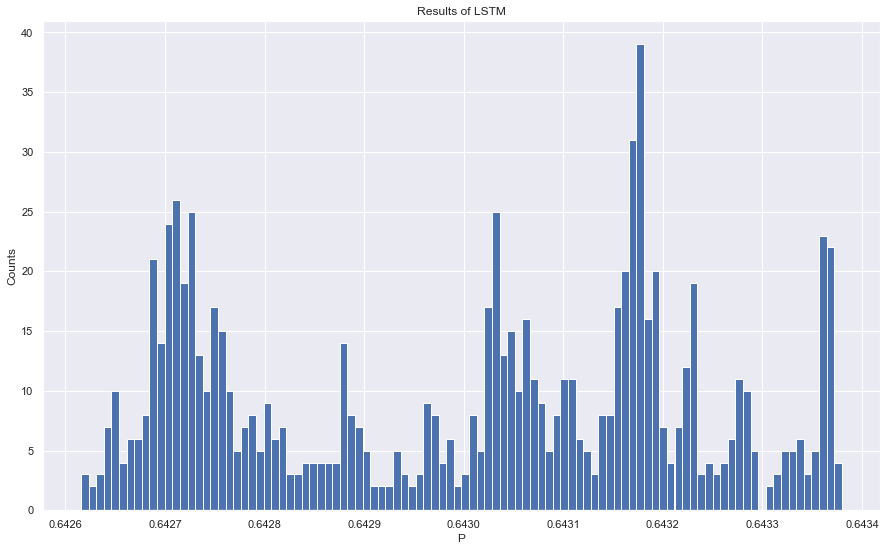

In [222]:
p = y_pred_lstm
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Results of LSTM')
plt.savefig('Prob.jpg')
plt.show()

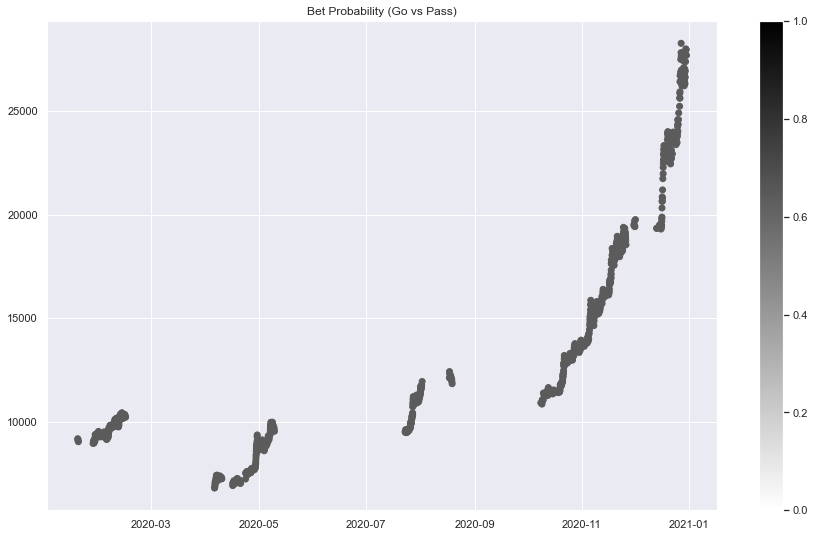

In [223]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_test.index, close.loc[y_test.index] ,c= y_pred_lstm, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.show()

## Bet Sizing

In [224]:
def get_signal(prob, num_classes, side=None):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    if not isinstance(side, type(None)):
        bet_sizes = side * (2 * norm.cdf(bet_sizes) - 1)
    else:
        bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [225]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [226]:
prob = y_pred_lstm
prob.index = y_test.index

m = get_signal(prob, 2, side.loc[prob.index])

Bet size scaling

In [227]:
mscaler = preprocessing.MinMaxScaler((0,1))
mscaler.fit(m.to_frame())
m_scaled = pd.DataFrame(mscaler.transform(m.to_frame()),columns=['m'],index=y_test.index)
m_scaled

,m
timestamp,
2020-01-19 02:00:00,0.548283
2020-01-19 05:00:00,0.558336
2020-01-19 06:30:00,0.557015
2020-01-19 10:30:00,0.546412
2020-01-27 19:00:00,0.546876
...,...
2020-12-29 23:30:00,0.038268
2020-12-30 00:00:00,0.022052
2020-12-30 02:30:00,0.042027


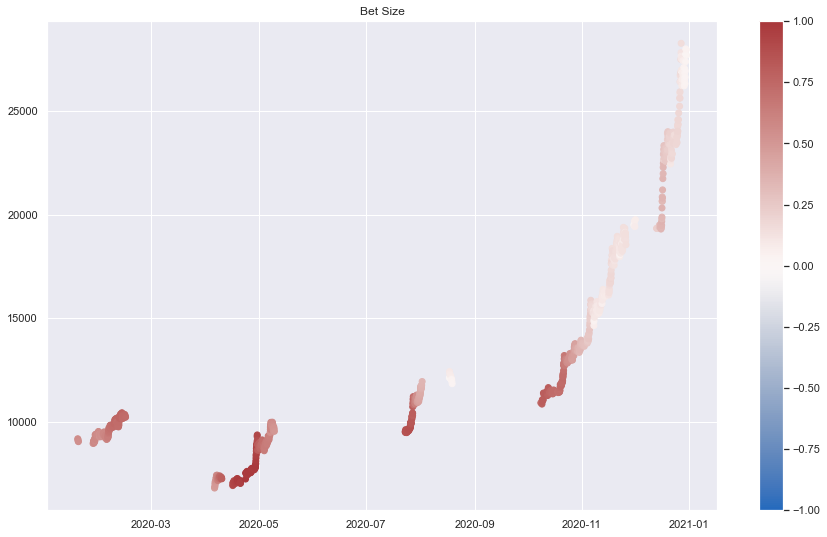

In [228]:
cmap = 'vlag'

plt.figure(figsize=(15,9))
plt.scatter(y_test.index, close.loc[y_test.index] ,c= m_scaled.m, cmap=cmap,vmin=-1,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('betsize.jpg')
plt.show()

# Trading

In [229]:
longret = bin.ret*bin.side

# Trend Prediction
firstret = longret*side.loc[y_test.index]
cumrfret = firstret.cumsum()


# Bet sizing with LSTM
bsret = longret*m_scaled.m
cumbsret = bsret.cumsum()

# Buy and Hold
buyholdret = (close.loc[y_test.index][-1]-close.loc[y_test.index][0])/close.loc[y_test.index][0]
bh = pd.Series(0, index=y_test.index)
bh.iloc[-1] = buyholdret

# Results

## Returns

In [230]:
dfret = pd.DataFrame({  'Trading Strategy':firstret,
                           'Bet Sizing':bsret,
                     'Buy and Hold':bh})
dfret.describe()

,Trading Strategy,Bet Sizing,Buy and Hold
count,911.000000,911.000000,911.000000
mean,0.007083,0.003391,0.002213
std,0.034949,0.018995,0.066799
min,-0.133955,-0.076554,0.000000
25%,-0.024502,-0.007846,0.000000
50%,0.019913,0.005868,0.000000
75%,0.031722,0.014651,0.000000
max,0.070631,0.063391,2.016191


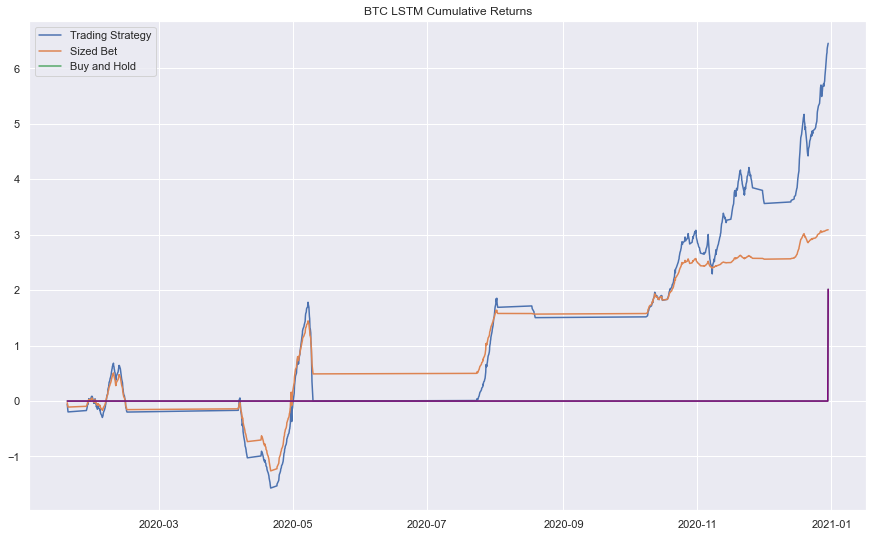

In [231]:
plotcumret = pd.DataFrame({'Trading Strategy':cumrfret,
                           'Sized Bet':cumbsret,
                           'Buy and Hold':bh})

plt.figure(figsize=(15,9))
plt.title('BTC LSTM Cumulative Returns')
plt.plot(plotcumret)


# Purple line is buy and hold
plt.plot(bh ,color='purple')
plt.legend(plotcumret)
plt.savefig('BTCUSD LSTM cumret.jpg')
plt.show()

In [232]:
def sr(df):
    out = pd.DataFrame(index=['BTC Annualized Sharpe Ratio'])
    for c in df.columns:
        out[c] = (df[c].mean()/df[c].std())*((mt*365)**0.5)
    return out

In [233]:
df_sr = sr(dfret).style.highlight_max(axis=1)
df_sr

,Trading Strategy,Bet Sizing,Buy and Hold
BTC Annualized Sharpe Ratio,26.826540,23.632912,4.385386


In [234]:
import dataframe_image as dfi
dfi.export(df_sr, 'BTCUSD LSTM Annualized Sharpe Ratio.png')